In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature

datafile = './Data/data_raw.csv'
raw_df = pd.read_csv(datafile)

# Load the spreadsheet data and get ready for gplates

In [6]:
# For use in gplates - have to run gplates under a different environment
orig_ll = raw_df[['lng', 'lat']].to_numpy()
max_age = raw_df['max_ma'].to_numpy()
min_age = raw_df['min_ma'].to_numpy()

np.save('gplates_input.npy', {'orig_ll':orig_ll, 'max_age':max_age, 'min_age':min_age})

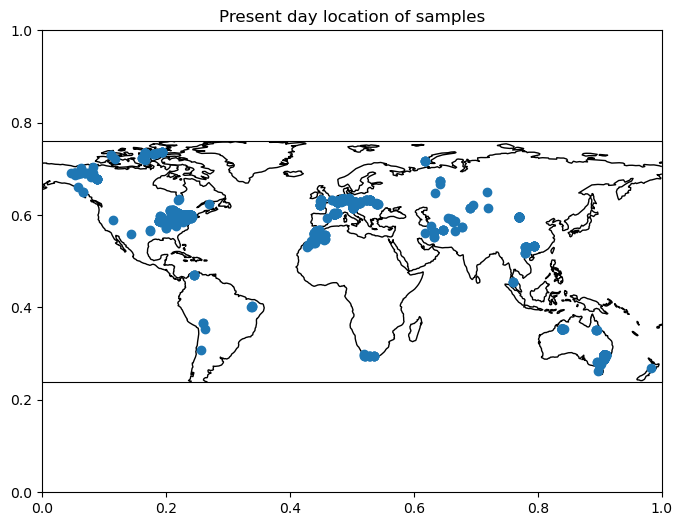

In [7]:
fig = plt.figure(figsize=(8,6))
plt.title('Present day location of samples')
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
plt.scatter(orig_ll[:,0], orig_ll[:,1], transform=crs.PlateCarree(), zorder=2)


Text(0, 0.5, 'Min age')

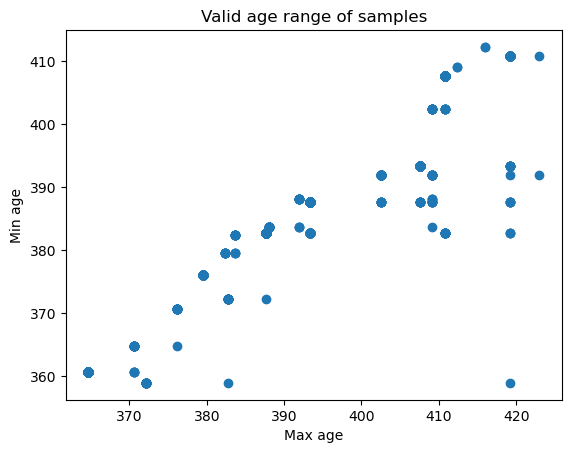

In [8]:
plt.title('Valid age range of samples')
plt.scatter(max_age, min_age)
plt.xlabel('Max age')
plt.ylabel('Min age')

# Load gplates reconstruction and parachute data

The calcs for gplates and scraping the parachute index need other code environments so they are done outside and loaded here. The gplates reconstruction was done for every point at 5ma intervals for every point so that I can get distances between points at a reasonable average age.

In [12]:
# Load the gplates output
gplates_ll = np.load('./Code/r_ll.npy', allow_pickle=True).item()
gplates_poly = np.load('./Code/r_poly.npy', allow_pickle=True).item()

# Load the parachute index
pari_datafile = './Data/paleo-imperialism/pari.csv'
pari_df = pd.read_csv(pari_datafile)

# Get the pari index for each sample
samp_pari = []
for this_cc in raw_df['cc']:
    this_pari = pari_df.loc[pari_df['alpha.2'] == this_cc]['index'].to_numpy()
    if len(this_pari) == 0:
        samp_pari.append(0)
    else:
        samp_pari.append(this_pari[0])

# Analysis attempts

I've used the parachute index as   

I use bugs as the generic term for the taxomic rank; I'm currently working with genus but this can be changed easily by changing the 'chosen_level'.

Then I split the data into two dictionaries: 'Single' where all the samples are from the same parachute class and both where they have been found in both countries with parachute > 0 and < 0. To label these I've used gt0 for the positive parachute inde

First I have a look at the number of samples found in gt0/lt0 respectively and partition them by which they were first discovered (by publication date)

In [13]:
#  Start analysis at chosen level
chosen_level = 'genus'
base = 5 # The intervals of time used

both = {}
single = {}

for this_choose in np.unique(raw_df[chosen_level]):
    ind = raw_df[chosen_level] == this_choose
    this_pari = np.asarray(samp_pari)[ind.to_numpy()]
    if np.sum(this_pari > 0) > 0 and np.sum(this_pari < 0) > 0:
        target_dict = both
    else:
        target_dict = single

    sub_df = raw_df[ind][['max_ma', 'min_ma', 'ref_pubyr', 'cc', 'lng', 'lat']]
    sub_df['pari'] = this_pari
    
    """
    # Original code but realised that for distances should use the 
    base = 5
    mean_age = []
    for amin, amax in zip(sub_df['min_ma'], sub_df['max_ma']):
    mean_age.append(base * round(np.mean([amin, amax])/base))
    r_ll = []
    for this_age, this_ind in zip(mean_age, sub_df.index.to_numpy()):
        r_ll.append(gplates_ll[this_age][this_ind])
    """
    mean_age = base * round(np.mean([np.mean(sub_df['min_ma']), np.mean(sub_df['max_ma'])])/base)
    r_ll = np.asarray(gplates_ll[mean_age])[ind.to_numpy()]
    mean_age = np.tile(mean_age, this_pari.shape)

    sub_df['ma'] = np.asarray(mean_age)
    sub_df['r_lat'] = np.asarray(r_ll)[:,0]
    sub_df['r_lon'] = np.asarray(r_ll)[:,1]
    
    if len(this_pari) > 1:
        target_dict[this_choose] = sub_df

In [14]:
# Check number of entries for each 
for this_key, this_data in both.items():
    print(f'{this_key} has {this_data.shape[0]} entries')

Acanthopyge (Acanthopyge) has 4 entries
Acanthopyge (Perunaspis) has 7 entries
Acuticryphops has 9 entries
Basidechenella has 46 entries
Belenopyge has 34 entries
Buchiproetus has 9 entries
Ceratarges has 7 entries
Chlupaciparia has 5 entries
Coniproetus (Coniproetus) has 13 entries
Cornuproetus (Cornuproetus) has 7 entries
Crassiproetus has 16 entries
Cyphaspis has 7 entries
Dechenella has 44 entries
Eldredgeops has 240 entries
Eskoharpes has 11 entries
Gandlops has 4 entries
Gerastos has 21 entries
Gerastos (Erbenites) has 3 entries
Gondwanaspis has 10 entries
Harpes has 15 entries
Koneprusia has 5 entries
Leonaspis has 19 entries
Lepidoproetus has 17 entries
Lioharpes has 18 entries
Neocalmonia has 5 entries
Nephranops (Nephranops) has 5 entries
Orbitoproetus has 5 entries
Osmolskabole has 5 entries
Otarion has 22 entries
Phacops has 29 entries
Podoliproetus has 6 entries
Proetopeltis has 6 entries
Proetus has 11 entries
Psychopyge has 5 entries
Radiopyge has 7 entries
Raerinproetus

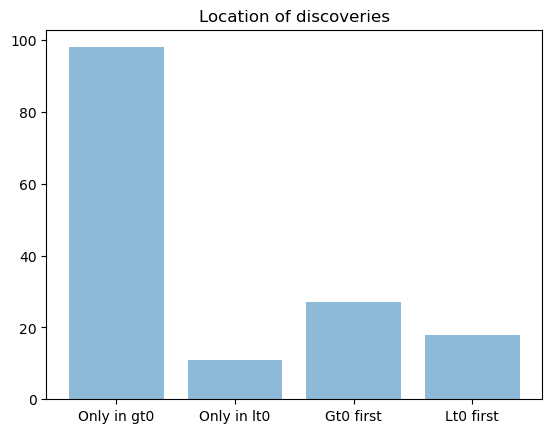

In [15]:
from collections import OrderedDict

all_pari_single= []
for this_df in single.values():
    all_pari_single.append(this_df['pari'].to_numpy()[0])
all_pari_single = np.asarray(all_pari_single)

all_pari_both = []
for this_df in both.values():
    all_pari_both.append(this_df.sort_values('ref_pubyr').iloc[0]['pari'])
all_pari_both = np.asarray(all_pari_both)

seq_stats = OrderedDict({'Only in gt0':np.sum(all_pari_single>0), 'Only in lt0':np.sum(all_pari_single<0),
                            'Gt0 first':np.sum(all_pari_both>0), 'Lt0 first':np.sum(all_pari_both<0)})

y_pos = np.arange(len(seq_stats.values()))

plt.bar(y_pos, seq_stats.values(), align='center', alpha=0.5)
plt.xticks(y_pos, seq_stats.keys())
plt.title('Location of discoveries')

plt.show()

So we have 98 samples found only in gt0 countries, 11 in only lt0 countries, 27 were found in gt0 first and 18 in lt0 first

In [16]:
both_scatter = []
both_first = []
for this_df in both.values():
    this_pari = this_df['pari']
    both_scatter.append([np.sum(this_pari > 0), np.sum(this_pari < 0)])
    both_first.append(this_df.sort_values('ref_pubyr').iloc[0]['pari'])
both_scatter = np.asarray(both_scatter)
both_first = np.asarray(both_first)

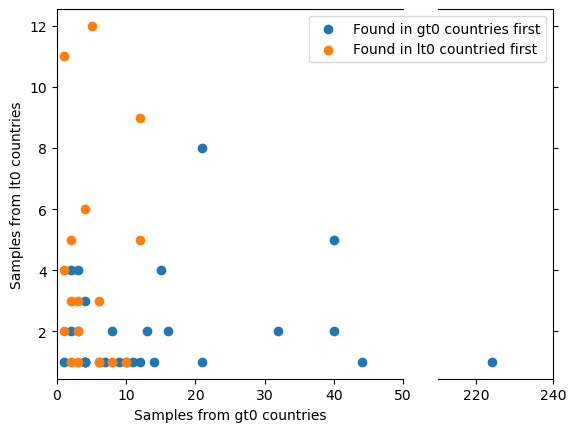

In [17]:
# Broken axis plotting nicked from https://stackoverflow.com/questions/5656798/is-there-a-way-to-make-a-discontinuous-axis-in-matplotlib

fig,(ax,ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={'width_ratios': [3, 1]})
ax.scatter(both_scatter[both_first > 0, 0], both_scatter[both_first > 0, 1])
ax.scatter(both_scatter[both_first < 0, 0], both_scatter[both_first < 0, 1])

ax2.scatter(both_scatter[both_first > 0, 0], both_scatter[both_first > 0, 1])
ax2.scatter(both_scatter[both_first < 0, 0], both_scatter[both_first < 0, 1])

ax.set_xlim(0,50) # most of the data
ax2.set_xlim(210,240) # outliers only

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
#ax.yaxis.tick_left()
#ax.tick_params(labeltop='off') # don't put tick labels at the top
ax2.yaxis.tick_right()

ax.set_ylabel('Samples from lt0 countries')
ax.set_xlabel('Samples from gt0 countries')

ax2.legend(['Found in gt0 countries first', 'Found in lt0 countried first'])
# Make the spacing between the two axes a bit smaller
plt.subplots_adjust(wspace=0.15)


# Calculate paleo distance

Now I have a look at the paleo distances. There are some complications here; with multiple samples to compare to which should you use for the distance and with multiple time slices which gplates reconstruction do you use for the distance

For now I look at the minimum between a given lt0 sample and any gt0 sample and for comparison look at the max and mean distance within the gt0 samples. I do the same for things only found in gt0 too for comparison. For the time slices it seems to only make sense to do it on the same time slice so I take 

Eventually I think I should do some sort of density clustering to define the times and spaces but this will do for a first look.

I also work with two different metrics for distance; one is standard euclidian distance (well not actually euclidean as its on a sphere but you know what I mean, or at least you probably did before I clarified it :-p) and the other is an attempt to capture 'land connectedness'. This does assume these bugs are land based but I know no better...

In [18]:
# Plot the distance metrics

In [19]:
# Two different types of paleo distance; normal and inflating the continents

this_bug = 'Eldredgeops'

this_df = both[this_bug]

this_gt0_locs = this_df.loc[this_df['pari']>0][['lng', 'lat']].to_numpy()
this_lt0_locs = this_df.loc[this_df['pari']<0][['lng', 'lat']].to_numpy()

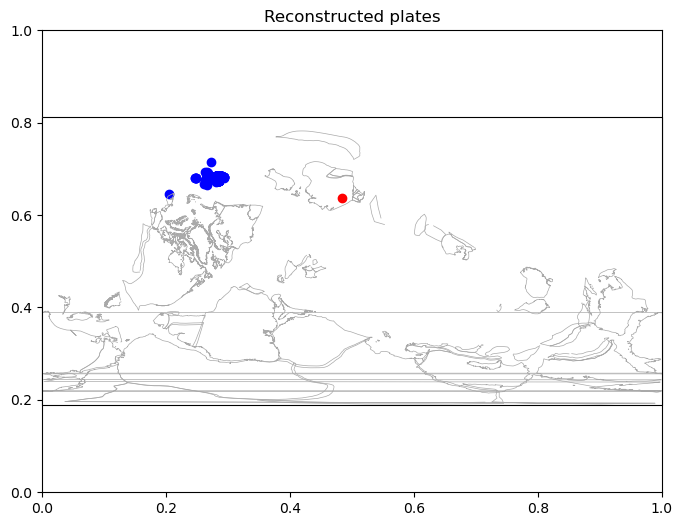

In [20]:
#for plon, plat in zip(gplates_poly[time][0], gplates_poly[time][1]):
#   ...:         plt.plot(plon, plat, c='darkgray', linewidth=0.5)

time = this_df['ma'].to_numpy()[0]

fig = plt.figure(figsize=(8,6))
plt.title('Reconstructed plates')
ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
#ax.add_feature(cfeature.COASTLINE)
plt.scatter(this_gt0_locs[:,0], this_gt0_locs[:,1], c='b', transform=crs.PlateCarree(), zorder=2)
plt.scatter(this_lt0_locs[:,0], this_lt0_locs[:,1], c='r', transform=crs.PlateCarree(), zorder=2)
for plon, plat in zip(gplates_poly[time][0], gplates_poly[time][1]):
    plt.plot(plon, plat, c='darkgray', transform=crs.PlateCarree(), linewidth=0.5)

In [22]:
# Run the dists for everything
import haversine as h
eucl_dist = {}
for this_bug in both.keys():
    this_df = both[this_bug]

    this_gt0_locs = this_df.loc[this_df['pari']>0][['lng', 'lat']].to_numpy()
    this_lt0_locs = this_df.loc[this_df['pari']<0][['lng', 'lat']].to_numpy()
    
    lt_first = this_df.sort_values('ref_pubyr').iloc[0]['pari'] < 0

    # Should vectorise but meh
    dists = []
    for i in np.arange(0,len(this_gt0_locs)):
        for j in np.arange(0,len(this_gt0_locs)):
            dists.append(h.haversine([this_gt0_locs[i,1],this_gt0_locs[i,0]], [this_gt0_locs[j,1],this_gt0_locs[j,0]]))
    dists = np.asarray(dists)
    dists = dists[dists != 0]
    if dists.size == 0:
        dists = np.asarray([0])

    dists_lt = []
    for i in np.arange(0,len(this_lt0_locs)):
        temp = []
        for j in np.arange(0,len(this_gt0_locs)):
            temp.append(h.haversine([this_lt0_locs[i,1],this_lt0_locs[i,0]], [this_gt0_locs[j,1],this_gt0_locs[j,0]]))
        dists_lt.append(np.min(temp))

    dists_lt = np.asarray(dists_lt)
    if dists.size != 0 and dists_lt.size != 0:
        eucl_dist[this_bug] = [dists, dists_lt, lt_first]

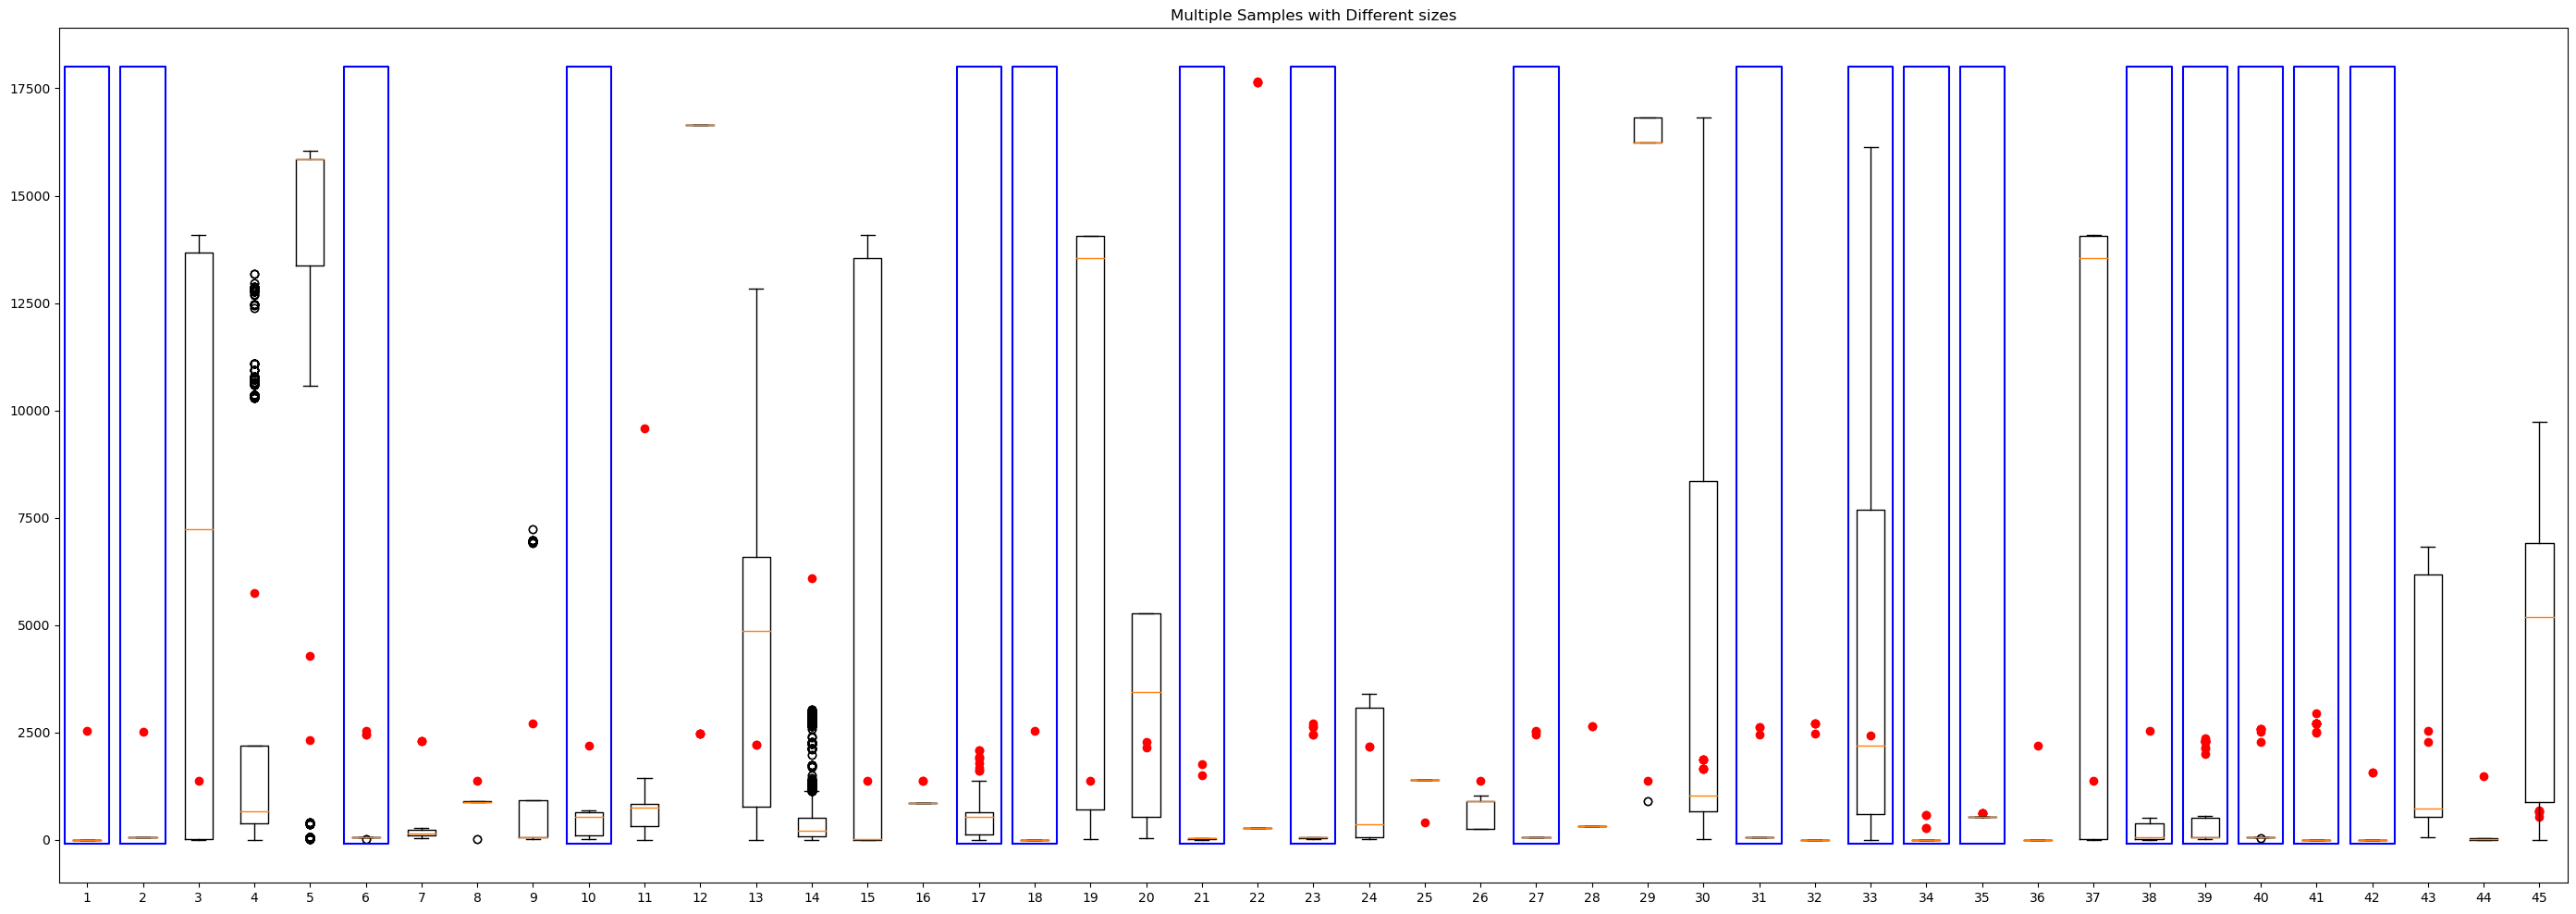

In [23]:
# Plot as bw plots, turns out I made the array the wrong way round for that
plot_gt = []
plot_lt = []
lt_first = []
for this_val in eucl_dist.values():
    plot_gt.append(this_val[0])
    plot_lt.append(this_val[1])
    lt_first.append(this_val[2])
    
fig, ax = plt.subplots(figsize=[35,12])
ax.set_title('Multiple Samples with Different sizes')
ax.boxplot(plot_gt)
for i, val in enumerate(plot_lt):
    ax.scatter(np.ones(len(val))*(i+1), val, c='r')
    if lt_first[i]:
        x = [i+0.6, i+1.4, i+1.4, i+0.6, i+0.6]
        y = [-100, -100, 18000, 18000, -100]
        ax.plot(x,y,c='b')

In [ ]:
for this_bug, this_df in both.items():
    this_gt0_locs = this_df.loc[this_df['pari']>0][['lng', 'lat']].to_numpy()
    this_lt0_locs = this_df.loc[this_df['pari']<0][['lng', 'lat']].to_numpy()
    
    time = this_df['ma'].to_numpy()[0]

    fig = plt.figure(figsize=(8,6))
    plt.title(this_bug)
    ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())
    #ax.add_feature(cfeature.COASTLINE)
    plt.scatter(this_gt0_locs[:,0], this_gt0_locs[:,1], c='b', transform=crs.PlateCarree(), zorder=2)
    plt.scatter(this_lt0_locs[:,0], this_lt0_locs[:,1], c='r', transform=crs.PlateCarree(), zorder=2)
    for plon, plat in zip(gplates_poly[time][0], gplates_poly[time][1]):
        plt.plot(plon, plat, c='darkgray', transform=crs.PlateCarree(), linewidth=0.5)

/tmp/ipykernel_6779/1705273877.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(8,6))
